In [159]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [7]:
link = 'https://raw.githubusercontent.com/kvolkov777/ds_project/main/weather_dataset.csv'
r = requests.get(link).text
#не будем озадачиваться парсингом данных, возьмем готовый полноценный датасет в формате csv

In [118]:
data = {}
for i in range(len(r.split('\r\n')[6].split(';'))):
    data[r.split('\r\n')[6].split(';')[i][1:-1]] = []
#заведем имена фичей в будущем датафрейме
#для удобства сразу выкинем излишне вычурные фичи и переименуем акутальные, чтобы выглядело понятнее
data['Time'] = data.pop('Местное время в Санкт-Петербурге')
data['Temperature'] = data.pop('T')
data['Pressure'] = data.pop('P')
data['Humidity'] = data.pop('U')
data['Wind_direction'] = data.pop('DD')
data['Wind_speed'] = data.pop('Ff')
data['Cloudiness'] = data.pop('N')
data['Cloud_height'] = data.pop('H')
data['Visibility'] = data.pop('VV')
data['Precipitation'] = data.pop('RRR')
data.pop('sss')
data.pop('Po')
data.pop('Pa')
data.pop('ff10')
data.pop('ff3')
data.pop('WW')
data.pop('W1')
data.pop('W2')
data.pop('Tn')
data.pop('Tx')
data.pop('Cl')
data.pop('Nh')
data.pop('Cm')
data.pop('Ch')
data.pop('Td')
data.pop('E')
data.pop('Tg')
data.pop("E'")
data.pop('tR')
print('Итоговые признаки датасета:', end = ' ')
print(*list(data.keys()), sep = ', ')

Итоговые признаки датасета: Time, Temperature, Pressure, Humidity, Wind_direction, Wind_speed, Cloudiness, Cloud_height, Visibility, Precipitation


In [96]:
#warning! следующая ячейка, обрабатывающая файл, работает очень долго (у меня она выполнялась порядка 2,5 часов)

In [79]:
flag = 0
r1 = ''
for symbol in r: 
    if symbol == ';' and flag == 0:
        r1 += symbol
    elif symbol != ';' and symbol != '"':
        r1 += symbol
    elif flag == 0 and symbol == '"':
        flag = 1
        r1 += symbol
    elif flag == 1 and symbol == '"':
        flag = 0
        r1 += symbol
#данная ячейка выполняется всвязи с тем, что в файле csv сепаратором служит ";"
#но также точка с запятой используется в данных, поэтому из данных я ее удаляю, чтобы не было ошибок при сплите

In [119]:
#я немного сократил количество наблюдений (до 12000). так код выполняется чуть корректнее и быстрее
#а практической ценности проекту величина датасета все равно не придаст :)
for observation in r1.split('\r\n')[7:12000]: 
    
    data['Time'].append(observation.split(';')[0][1:-1])
    
    data['Temperature'].append(float(observation.split(';')[1][1:-1]))
    
    data['Pressure'].append(float(observation.split(';')[3][1:-1]))

    if observation.split(';')[5][1:-1] != '':
        data['Humidity'].append(int(observation.split(';')[5][1:-1]))
    else:
        data['Humidity'].append(85)
    
    if observation.split(';')[6][1:-1] == 'Штиль, безветрие':
        data['Wind_direction'].append((0,0))
    else: 
        info = observation.split(';')[6][1:-1].split(' ')[-1]
        i = 0
        j = 0
        for k in info.split('-'): 
            if 'вост' in k: 
                i -= 1
            if 'зап' in k:
                i += 1
            if 'сев' in k:
                j -= 1
            if 'юг' in k:
                j +=1
        data['Wind_direction'].append((i,j))
        #я добавляю в значение признака вектор, сонаправленный с направлением ветра, если базисные векторы - восток и север

    if observation.split(';')[7][1:-1] != '':
        data['Wind_speed'].append(int(observation.split(';')[7][1:-1]))
    else:
        data['Wind_speed'].append(0)
    
    if not ('%' in observation.split(';')[10][1:-1]): 
        data['Cloudiness'].append(0)
        #нулевая обласность описана словами, при наличии численных данных всегда есть %
    else:
        data['Cloudiness'].append(int(observation.split(';')[10][1:-1].split(' ')[-1].split('–')[-1].split('%')[0]))
        #здесь я беру последнее число слева от процента
        #оно отстоит от среднего не более чем на 5%, что устраивает нас с высокой точностью
    
    
    if observation.split(';')[18][1:-1] == '':
        data['Cloud_height'].append(2500)
        #в датасете пропуски в этом признаке есть только при погоде, когда облаков нет
        #в таком случае мы будем писать высоту 2500 метров (максимальное идентифицируемое значение)
    elif '-' in observation.split(';')[18][1:-1]: 
        data['Cloud_height'].append(0.5*(int(observation.split(';')[18][1:-1].split('-')[0]) 
                                        + int(observation.split(';')[18][1:-1].split('-')[1])))
        #для обозначения высоты указывается интервал значений типа "300-600", мы будем брать среднее
    else:
        data['Cloud_height'].append(2500)
    
    if observation.split(';')[21][1:-1] == 'менее 0.05':
        data['Visibility'].append(0.05)
    else:
        data['Visibility'].append(float(observation.split(';')[21][1:-1]))
    
    if (observation.split(';')[23][1:-1] == 'Следы осадков') or (observation.split(';')[23][1:-1] == 'Осадков нет'):
        data['Precipitation'].append(0)
    elif observation.split(';')[23][1:-1] != '': 
        data['Precipitation'].append(float(observation.split(';')[23][1:-1]))
    else: 
        data['Precipitation'].append(0.0)
        #наблюдения имеют интервал в 3 часа, но осадки в таблице записываются за 12 часов
        #поэтому будем записывать в пропуски нули, чтобы сохранять суммарные количества осадков за каждые сутки
df = pd.DataFrame(data)
df.head(10)
#теперь у нас наконец есть обработанный датасет и можно как нибудь его повизуализировать

,Time,Temperature,Pressure,Humidity,Wind_direction,Wind_speed,Cloudiness,Cloud_height,Visibility,Precipitation
0,01.01.2024 21:00,-17.4,768.1,81,"(-1, 0)",1,0,2500.0,10.0,0.2
1,01.01.2024 18:00,-17.0,767.5,79,"(-1, 0)",1,80,2500.0,10.0,0.2
2,01.01.2024 15:00,-15.3,766.6,82,"(0, 0)",0,0,450.0,10.0,0.0
3,01.01.2024 12:00,-14.1,766.0,88,"(-1, 0)",1,0,450.0,10.0,0.0
4,01.01.2024 09:00,-18.0,765.1,87,"(0, 0)",0,0,2500.0,10.0,0.2
5,01.01.2024 06:00,-16.9,764.2,90,"(0, 0)",0,100,1250.0,10.0,0.2
6,01.01.2024 03:00,-14.0,763.4,91,"(0, 0)",0,100,450.0,10.0,0.0
7,01.01.2024 00:00,-12.7,762.5,89,"(0, -1)",1,100,450.0,4.0,0.0
8,31.12.2023 21:00,-12.5,761.4,88,"(0, -1)",1,100,450.0,4.0,0.3
9,31.12.2023 18:00,-13.4,760.6,87,"(1, -1)",2,100,450.0,4.0,0.3


In [134]:
#построим корелляционную матрицу для параметров облачности, высоты облаков, осадков, влажности, видимости
df1 = pd.DataFrame(data, columns = ['Cloudiness', 'Cloud_height', 'Precipitation', 'Humidity', 'Visibility'])
df1.corr().style.background_gradient(cmap='RdYlGn')
#достаточно забавно, что единственные явно скореллированные параметры - высота облаков и облачность
#также есть слабая скореллированность высоты облаков с видимостью и облачности с влажностью, что кажтеся логичным
#хотелось бы еще видеть корелляцию между облачностью и осадками, но она очень очень слабо положительна

,Cloudiness,Cloud_height,Precipitation,Humidity,Visibility
Cloudiness,1.000000,-0.621388,0.123833,0.363743,-0.234080
Cloud_height,-0.621388,1.000000,-0.164350,-0.502180,0.344780
Precipitation,0.123833,-0.164350,1.000000,0.184498,-0.172872
Humidity,0.363743,-0.502180,0.184498,1.000000,-0.328018
Visibility,-0.234080,0.344780,-0.172872,-0.328018,1.000000


In [135]:
#возможно это связано с тем, что в Питере в целом очень большой средний уровень облачности почти в любую погоду
print('На налюбдаемом промежутке средний уровень покрытия неба облаками составил ' + str(int(sum(data['Cloudiness'])/len(data['Cloudiness']))) + '% - это, кажется, довольно много!')

На налюбдаемом промежутке средний уровень покрытия неба облаками составил 72% - это, кажется, довольно много!


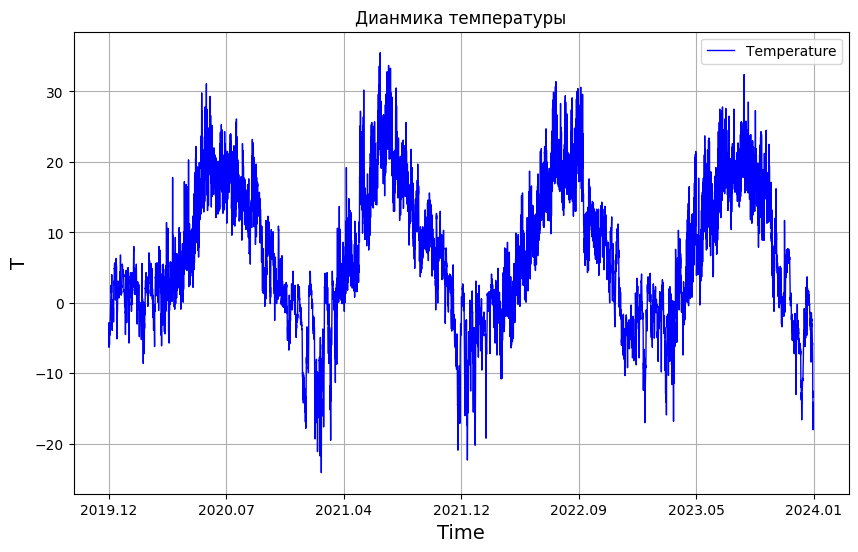

In [160]:
#теперь посмотрим на графики некоторых признаков на протяжении периода измерений
temp = list(df['Temperature'][::-1])
plt.figure(figsize=(10, 6))
plt.title("Дианмика температуры")
plt.plot(temp, color='b', linewidth=1, label='Тemperature')
plt.xlabel("Time", size=14)
plt.ylabel("T", size=14)
plt.xticks([0, 2000, 4000, 6000, 8000, 10000, 12000], ['2019.12', '2020.07', '2021.04', '2021.12', '2022.09', '2023.05', '2024.01'])
plt.grid()
plt.legend()

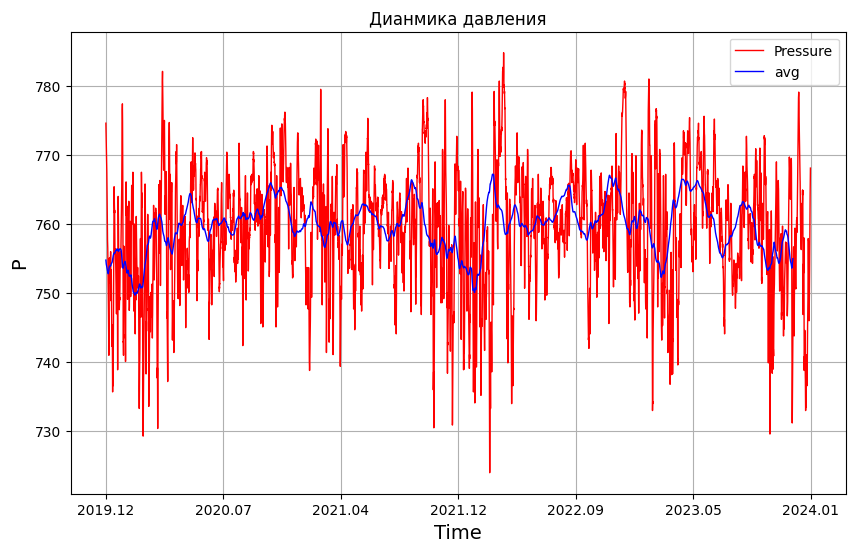

In [155]:
pres = list(df['Pressure'][::-1])
plt.figure(figsize=(10, 6))
plt.title("Дианмика давления")
plt.plot(pres, color='r', linewidth=1, label='Pressure')
#есть мнение, что при холодных температурах в среднем давление чуть меньше
#попробуем сделать график нагляднее при помощи скользящего среднего и визуально проверить эту гипотезу
plt.plot(list(pd.Series(pres).rolling(window=300).mean().iloc[299:].values), color='b', linewidth=1, label='avg')
plt.xlabel("Time", size=14)
plt.ylabel("P", size=14)
plt.xticks([0, 2000, 4000, 6000, 8000, 10000, 12000], ['2019.12', '2020.07', '2021.04', '2021.12', '2022.09', '2023.05', '2024.01'])
plt.grid()
plt.legend()
#видим, что до минимального значения в 750мм скользящее среднее опускается только в зимние месяцы,
#что говорит в пользу нашей гипотезы

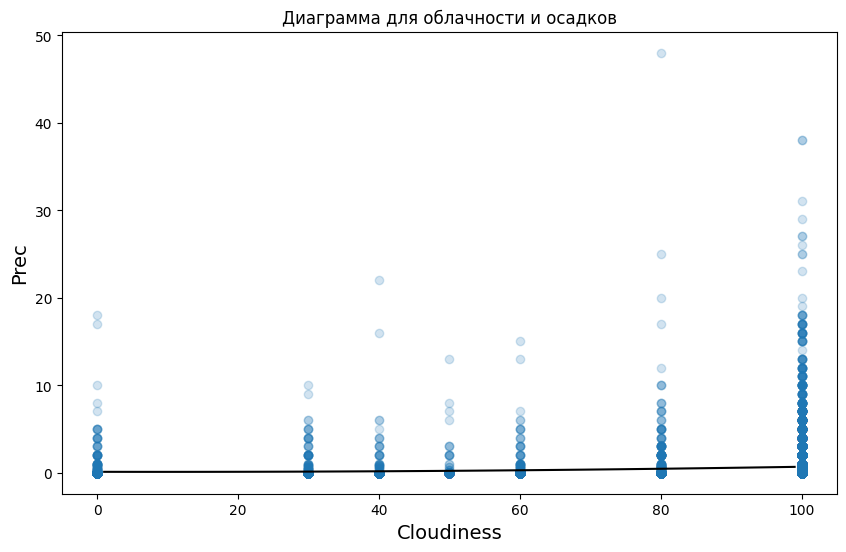

In [172]:
#попробуем детальнее посмотреть на ситуацию с корреляцией облачности и осадкой, построим диаграмму
plt.figure(figsize=(10, 6))
plt.title("Диаграмма для облачности и осадков")
plt.scatter(df['Cloudiness'], df['Precipitation'], alpha = 0.2)
plt.xlabel("Cloudiness", size=14)
plt.ylabel("Prec", size=14)

#при помощи метода наименьших квадратов в нумпай построим паработу, приближающую нашу диаграмму
#в данном случае хотелось бы апроксимировать именно квадратичной функцией, потому что заметно,
#что при бОльших значениях облачности зависимость становится сильнее (/вообще появлется)

coeffs = np.polyfit(df['Cloudiness'], df['Precipitation'], deg = 2)
list1 = []
list2 = []
for i in range(1,100):
    list1.append(i)
    list2.append(coeffs[2] + i * coeffs[1] + i * i * coeffs[0])
plt.plot(list1, list2, color = 'black')

#как мы видим, очень велик вес групп точек, где осадки близки к нулю
#это вынуждает метод наименьших квадратов проводить очень консервативную апроксимацию

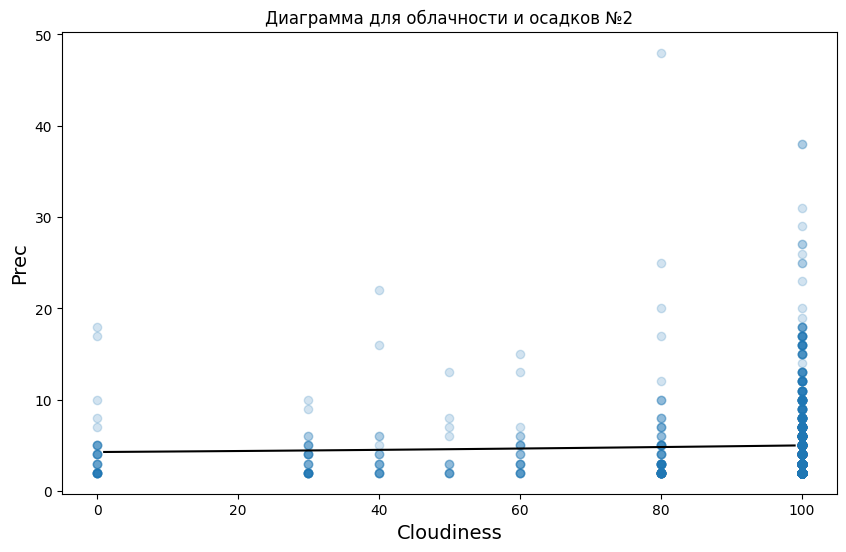

In [181]:
#посмотрим, что получится, если выкинуть околонулевые значения осадков (до миллиметра)
list_cloud = []
list_prec = []
for i in range(len(df['Precipitation'])):
    if df['Precipitation'][i] > 1:
        list_prec.append(df['Precipitation'][i])
        list_cloud.append(df['Cloudiness'][i])
plt.figure(figsize=(10, 6))
plt.title("Диаграмма для облачности и осадков №2")
plt.scatter(list_cloud, list_prec, alpha = 0.2)
plt.xlabel("Cloudiness", size=14)
plt.ylabel("Prec", size=14)

coeffs = np.polyfit(list_cloud, list_prec, deg = 2)
list1 = []
list2 = []
for i in range(1,100):
    list1.append(i)
    list2.append(coeffs[2] + i * coeffs[1] + i * i * coeffs[0])
plt.plot(list1, list2, color = 'black')
#а вот сейчас непонятно, почему мнк дает такой результат)) видимо, действительно сложно обнаружить связь
#между облачностью и осадками, хотя интуитивно и визуально она должна быть(

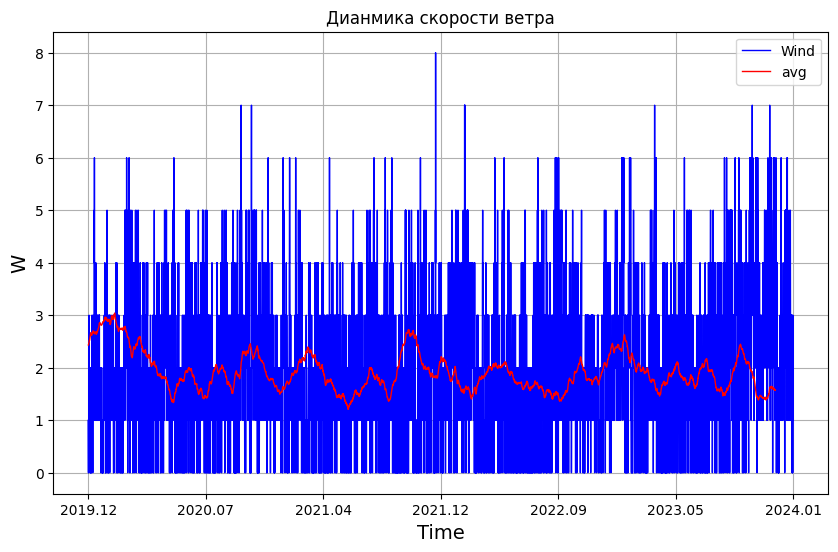

In [188]:
#теперь посмотрим на графики некоторых признаков на протяжении периода измерений
wind = df['Wind_speed'][::-1]
plt.figure(figsize=(10, 6))
plt.title("Дианмика скорости ветра")
plt.plot(wind, color='b', linewidth=1, label='Wind')
plt.plot(pd.Series(wind).rolling(window=300).mean().iloc[299:].values, color='r', linewidth=1, label='avg')
plt.xlabel("Time", size=14)
plt.ylabel("W", size=14)
plt.xticks([0, 2000, 4000, 6000, 8000, 10000, 12000], ['2019.12', '2020.07', '2021.04', '2021.12', '2022.09', '2023.05', '2024.01'])
plt.grid()
plt.legend()
#здесь сложно увидеть какую нибудь закономерность и предположить зависимость от прочих параметров
#а сможет ли машинное обучение?)
#проверим, как несложные модели предсказывают скорость ветра 

In [229]:
#чисто ради прикола будем использовать случайный лес
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
df1 = df[['Temperature', 'Pressure', 'Humidity', 'Cloudiness', 'Cloud_height', 'Visibility', 'Precipitation']]
list_east = []
list_north = []
for i in df['Wind_direction']:
    list_east.append(i[0])
    list_north.append(i[1])
df1['Wind_east'] = list_east
df1['Wind_north'] = list_north
df1 = np.array(df1)
target = np.array(df['Wind_speed'])
rf = RandomForestRegressor(max_features=4, n_estimators=300, random_state=229)
X_train, X_test, y_train, y_test = train_test_split(df1, target, test_size=0.25, random_state=11)
rf.fit(X_train, y_train)

/var/folders/dz/gyf4nkdd4wd3xby_n0sfcrkr0000gn/T/ipykernel_88845/2115094553.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['Wind_east'] = list_east
/var/folders/dz/gyf4nkdd4wd3xby_n0sfcrkr0000gn/T/ipykernel_88845/2115094553.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['Wind_north'] = list_north


RandomForestRegressor(max_features=4, n_estimators=300, random_state=229)

In [230]:
print(mean_squared_error(y_test, rf.predict(X_test)))
#очень неплохое mse!!!

0.67781963987996


In [232]:
importances = rf.feature_importances_
print(importances)
#ожидаемо, главными признаками оказались показатели направления ветра (северная и восточная компоненты)

[0.14928583 0.17722186 0.13024504 0.03260398 0.05266711 0.01359361
 0.02542013 0.2229335  0.19602894]


Итого мы обработали датасет с погодой в Санкт-Петербурге за последние годы, выяснили, что основные погодные
характеристики, вообще говоря, очень слабо скореллированы (исключая более менее очевидно взаимосвязанных
типа облачность/средняя высота облаков). Также мы, построив скользящее среднее, выяснили, что атм. давление
зимой ниже, чем в остальные времена года. Еще мы при помощи МНК и квадратичной апроксимации установили, что облачность
действительно слабо связана с осадками (предположительно по причине того, что в Питере в целом очень пасмурно почти всегда).
Наконец мы обучили случайный лес для предсказания скорости ветра и установили наиболее значимые признаки в модели. Ими оказались атмосферное давление и направление ветра (последнее, в целом, ожидаемо, принимае во внимание географическое положение города). 
Все!